<a href="https://colab.research.google.com/github/seedatnabeel/Pygotham2019_GANS/blob/master/GAN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks
# Pygotham 2019 - Nabeel Seedat



## Generative Adversarial Networks



At Pygotham 2019 -  this tutorial will introduce deep generative modelling specifically Generative Adversarial Networks (GANs)

We will learn the following:
* What is a GAN and how does it work
* What makes it hard to train GANs
* Tips and Tricks to make it easier to train GANs
* Get your hands dirty and train a GAN to generate pictures of clothes
* Links to resources to help you along your GAN journey


**NOTE**
Please enable the GPU on Google Colab to speed up training. Runtime ---> Change runtime type ---> Under hardware accelerator select GPU




[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs),are deep generative models which have made outstanding strides in making new data. They were proposed by Ian Goodfellow back in 2014 and have made immense progress since then with an explosion of applications. From face generation as shown in the picture below, to image-image translation, text-image generation and even Deepfakes.

Progress in face generation from Ian Goodfellow

![faces](https://pbs.twimg.com/media/Dw6ZIOlX4AMKL9J.jpg)

GANs are built on the premise of two neural networks fighting each other.
1. Generator: Who's goal is to produce new data - i.e. by producing a sample from some distribution of data
2. Discriminator: To tell the difference between the fake and real images

So the generator tries to fool the discriminator and the discriminator tries not to be fooled.




### Generative vs Discriminative models

You may be used to supervised learning as with most deep learning. This means we have data and labels and try learn the mapping from data (x) to labels (y). These are called discriminative models which learn $p(y | x)$.

On the otherhand we will be covering generative models. It's tempting to say isn't this simply unsupervised learning and so we don't utilize the labels for our data. While this is partially true it doesn't tell the full story. Why is this?

It's that unsupervised learning like K-means clustering is not generative. Moreover, generative models are not always unsupervised - sometimes they can be supervised or semi-supervised. See.

The major difference between generative and discrimative models is what they learn. As we said discrimiarive models predict the output $y$ for data $x$. Generative models try learn how the data is generated i.e. $p(x)$. If we know the process in which the data was generated - we can then make new examples of it! With a GAN this can be thought of as sampling from $p(x)$


In [1]:
#@title Package Import { display-mode: "form" }
!pip install tensorflow-gpu==2.0.0-beta0 > /dev/null 2>&1

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

try:
  tf.executing_eagerly()
  print("Imports successful")
except:
  print("Imports failed")

Imports successful


## Visual data: Fashion MNIST




Now it's time to have a look at the data that we will be using. To keep training time down we will use a grayscale image dataset called Fashion MNIST. You could use other datasets but the higher quality your images are the longer it will take to train. 

Fashion MNIST has grayscale pictures of clothes. There are 70000 images: 60000 train and 10000 test images. If we were doing supervised learning we would have used this split and the labels. However, for the GAN we don't need to learn labels - rather we want to learn the process that make these clothes pictures. So that we can make new examples!




#### Load the data

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train, train_labels), (test, test_labels) = fashion_mnist.load_data()



4423680/4422102 [==============================] - 0s 0us/step


#### Visualize the data

In [0]:
# used for visualization
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's see how these pictures look. The data is a 28 x 28 pixel image. The black is represented by value 0 and increasing darkness of greys until 255 which is black. The labels of the clothes are represented by numbers 1-9.

If you see the class labels list above. 0= T-shirt/top, 1= Trouser, 2=Pullover and so on

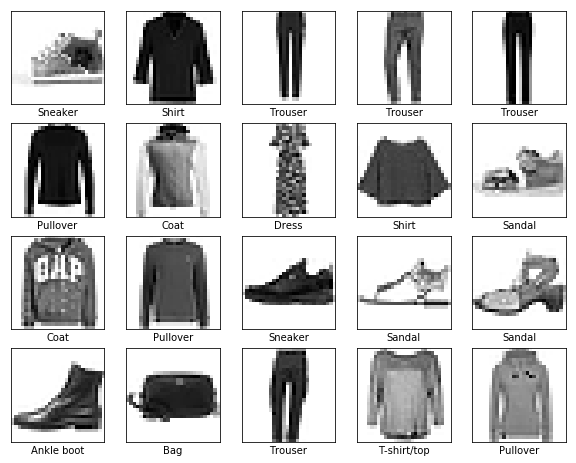

In [4]:
# We visualize 20 imqges of the data we will learn
plt.figure(figsize=(10,10))
for idx in range(20):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])

    # get a random image index
    img = np.random.randint(0, 50000)
    plt.imshow(train[img], cmap="gray_r")
    plt.xlabel(class_labels[train_labels[img]]) # print the class label for the image

## Onto some GAN Training to make those pretty pictures



Before we get into training our GAN let's define some steps:
* Process our data to get it in the correct form
* Define out GAN architecture - we need both a discriminator and generator
* Define the loss functions and optimizers for both
* Create our training loop


### Data pre-processing



We need to pre-process our data
.
1. Add an extra dimension. Why? Lots of layers will require an extra channel dimension. 
2. Normalize the images values to [-1, 1] Why? Based on the DCGAN guidelines & it means we centering our data with mean of zero
3. Randomize and batch the data. Why? Make training faster

In [0]:
images = np.expand_dims(train, axis=3) # add a channel dim
images = images.astype('float32') # convert to float32
images = (images - 127.5) / 127.5 # normalize the images to [-1, 1]
batch_size = 256
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(batch_size*10).batch(batch_size)

### GAN Architecture



We will be using the DCGAN architecture

#### Tips and Tricks from the authors of DCGAN



* Replace pooling layers with strided convolutions.
* Use batchnorm in both the generator and the discriminator
* Use ReLU activations in the generator, except last layer us Tanh to make sure outputs [-1,1]
* Use LeakyReLU activation in the discriminator for all layers.



#### Define the Generator



In [6]:
def generator():
  generator = tf.keras.Sequential(name="generator")
  

  generator.add(tf.keras.layers.Dense(7 * 7 * 128,
                                activation="relu",
                                input_dim=100))

  
  generator.add(tf.keras.layers.Reshape([7, 7, 128]))
  
  generator.add(tf.keras.layers.UpSampling2D())
  generator.add(tf.keras.layers.Conv2D(128,
                                 kernel_size=3,
                                 padding="same"))
  generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  generator.add(tf.keras.layers.Activation("relu"))
  
  generator.add(tf.keras.layers.UpSampling2D())
  generator.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=3,
                                 padding="same"))
  generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  generator.add(tf.keras.layers.Activation("relu"))
  
  generator.add(tf.keras.layers.Conv2D(1,
                                 kernel_size=3,
                                 padding="same"))
  generator.add(tf.keras.layers.Activation("tanh"))
  
  
  return generator
  
generator = generator()    

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0 

#### Define the Discriminator





In [7]:
def discriminator():
  
  discriminator = tf.keras.Sequential(name="discriminator")
  
  discriminator.add(tf.keras.layers.Conv2D(32,
                                  kernel_size=3,
                                  strides=2,
                                  padding="same",
                                  input_shape=(28,28,1)))

  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Conv2D(64,
                                  kernel_size=3,
                                  strides=2,
                                  padding="same"))
  discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Conv2D(128,
                                  kernel_size=3,
                                  strides=2,
                                  padding="same"))
  discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Conv2D(256,
                                  kernel_size=3,
                                  strides=1,
                                  padding="same"))
  discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Flatten())
  discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  
    
  return discriminator
  
discriminator = discriminator()    

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)        

#### Loss Functions


Define the discriminator loss.

- Role of the discriminator: determine is an image fake or real ---> binary classifier
- So ideally we predict 1 for a real image and 0 for a fake.
- Cross entropy is the standard loss for binary classifiers
- So we can do cross entropy for the real and for the fake. Then combine the two losses


In [0]:
# define the loss function for the discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_images, fake_images):
    # real_output is the prediction of the discriminator for a batch of real images
    # fake_output is the same but for images from the generator
    real_loss = cross_entropy(tf.ones_like(real_images), real_images)
    fake_loss = cross_entropy(tf.zeros_like(fake_images), fake_images)
    total_loss = real_loss + fake_loss
    return total_loss

Define the generator loss.

- Role of the generator is to trick the discriminator.
- So the generator loss uses the discriminators predictions i.e. to make itself better
- We train the generator to make the discrimator predict real (1) for the fake image

This is the adversarial nature - the loss functions are at odds with each other

In [0]:
def generator_loss(fake_images):
    return cross_entropy(tf.ones_like(fake_images), fake_images)

Since we have 2 different networks, we need 2 different optimizers. The hyper-parameters of the type of optimizer and learning rate are defined below. But feel free to play around with them - you may do better!

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define the training loop

* We train both the generator and discriminator networks
* Step 1: Generate random noise
* Step 2: Generate an image using the generator with the random noise as input
* Step 3: Pass a real image and the generated image through the discriminator
* Step 4: Compute the loss for the generator and discriminator
* Step 5: Compute the mean loss for the batch
* Step 6: Compute the gradient using the losses for both generator and discriminator i.e. autodiff for backprop
* Step 7: Apply the optimizer to take the gradient "step"
* Step 8: Repeat till epochs completed

Note the usage of tf.GradientTape()


## Let's train the GAN

In [0]:

gen_loss_mean = tf.keras.metrics.Mean(name='gen_loss_mean')
disc_loss_mean = tf.keras.metrics.Mean(name='disc_loss_mean')

@tf.function
def train_step(images):                                       
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_images = discriminator(images, training=True)
      fake_images = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_images)
      disc_loss = discriminator_loss(real_images, fake_images)

    gen_loss_mean(gen_loss)
    disc_loss_mean(disc_loss)
      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

noise = np.random.normal(0, 1, (8, 100))

def generate_images(generator):
    imgs = generator(noise, training=False)
      
    fig = plt.figure(figsize=(16,2))

    for i in range(imgs.shape[0]):
      plt.subplot(1, 8, i+1)
      plt.imshow(imgs[i, :, :, 0], cmap='gray_r')
      plt.axis('off')

    plt.show()
    
def train_GAN(epochs):
  generate_images(generator)
  
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
      
    display= 'Epoch {:03d}: time {:.3f} sec, gen loss {:.3f}, disc loss {:.3f}'
    print(display.format(epoch + 1, time.time()-start, gen_loss_mean.result(), disc_loss_mean.result()))
    
    generate_images(generator)


We will train for 20 epochs which should take 5min on the colab GPU. If you want more crisp results increase the epochs to around 50

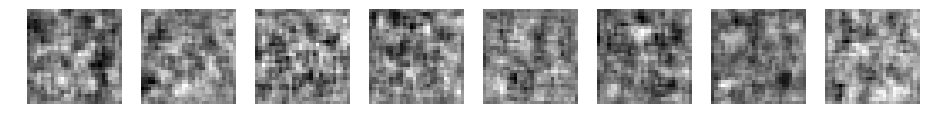

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 001: time 34.432 sec, gen loss 1.910, disc loss 1.106


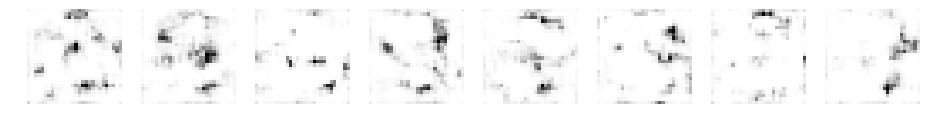

Epoch 002: time 27.584 sec, gen loss 2.051, disc loss 1.049


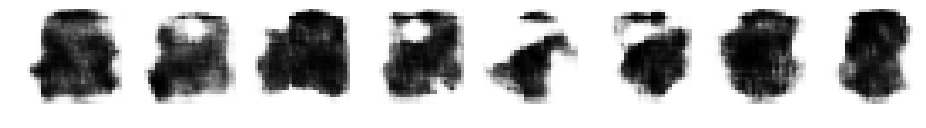

Epoch 003: time 27.634 sec, gen loss 1.860, disc loss 1.081


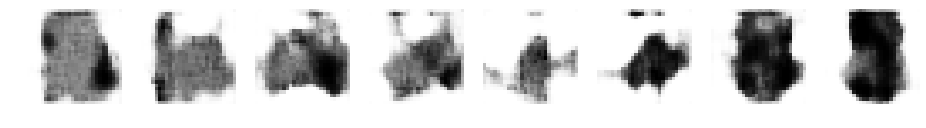

Epoch 004: time 27.792 sec, gen loss 1.742, disc loss 1.070


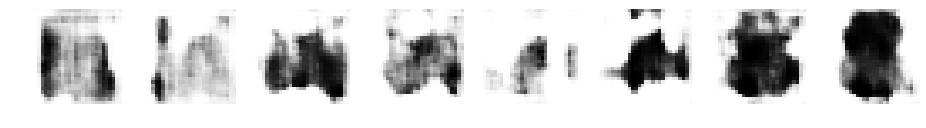

Epoch 005: time 27.898 sec, gen loss 1.704, disc loss 1.044


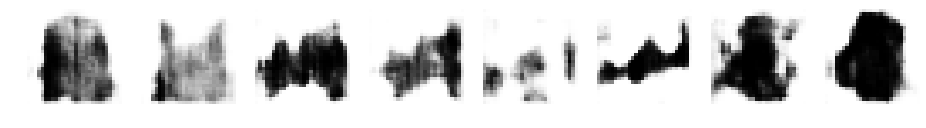

Epoch 006: time 27.866 sec, gen loss 1.684, disc loss 1.024


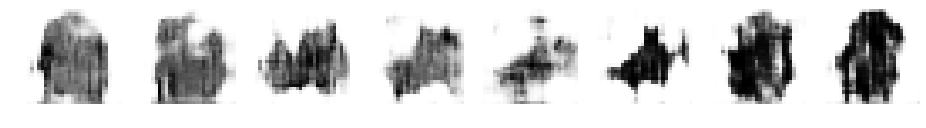

Epoch 007: time 27.878 sec, gen loss 1.683, disc loss 0.995


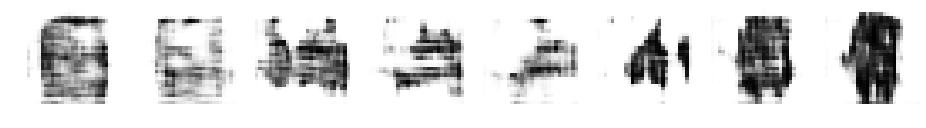

Epoch 008: time 27.875 sec, gen loss 1.673, disc loss 0.986


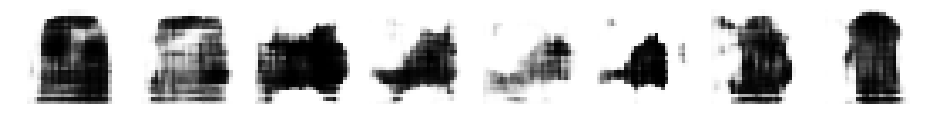

Epoch 009: time 27.845 sec, gen loss 1.667, disc loss 0.979


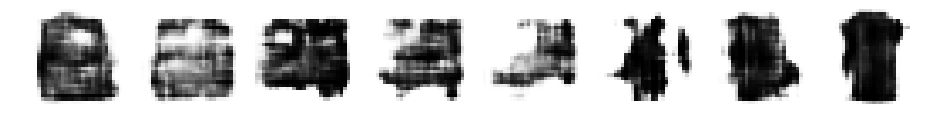

Epoch 010: time 27.904 sec, gen loss 1.677, disc loss 0.962


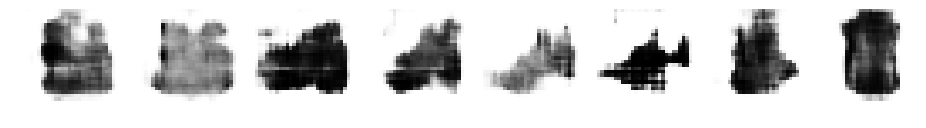

Epoch 011: time 27.883 sec, gen loss 1.685, disc loss 0.955


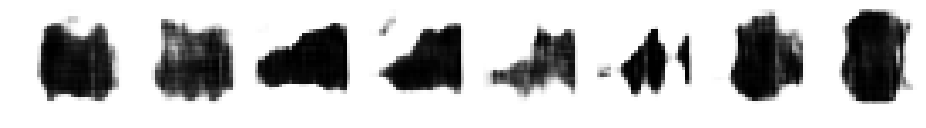

Epoch 012: time 27.881 sec, gen loss 1.694, disc loss 0.941


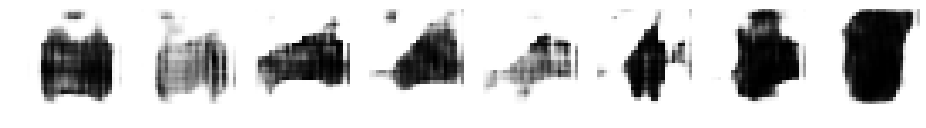

Epoch 013: time 27.729 sec, gen loss 1.701, disc loss 0.936


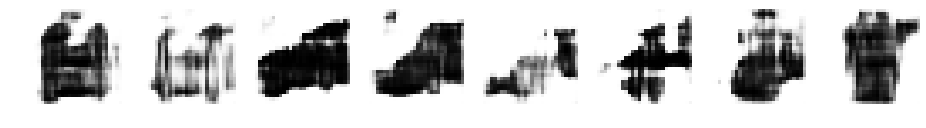

Epoch 014: time 27.656 sec, gen loss 1.712, disc loss 0.924


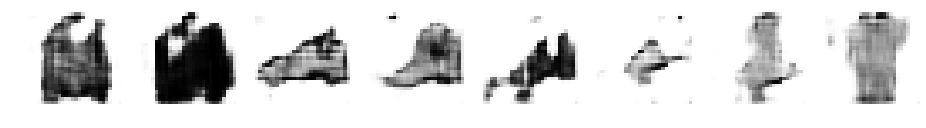

Epoch 015: time 27.882 sec, gen loss 1.714, disc loss 0.918


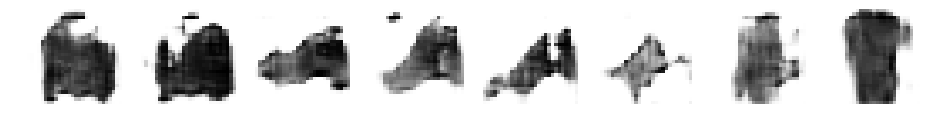

Epoch 016: time 27.680 sec, gen loss 1.709, disc loss 0.916


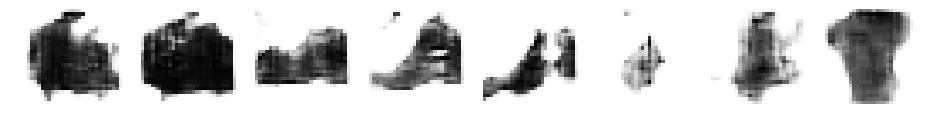

Epoch 017: time 27.884 sec, gen loss 1.701, disc loss 0.917


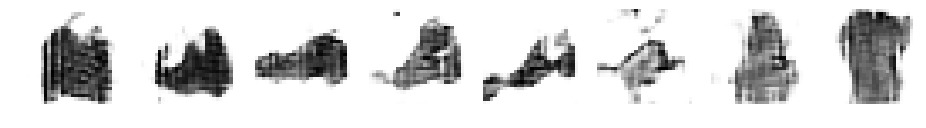

Epoch 018: time 27.741 sec, gen loss 1.698, disc loss 0.917


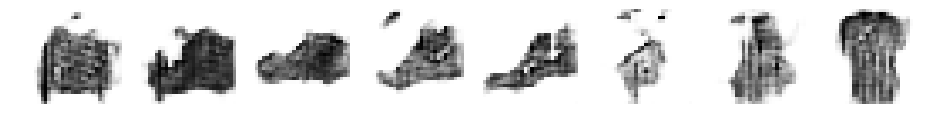

Epoch 019: time 27.777 sec, gen loss 1.691, disc loss 0.918


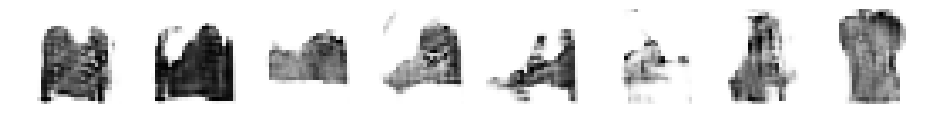

Epoch 020: time 27.651 sec, gen loss 1.687, disc loss 0.917


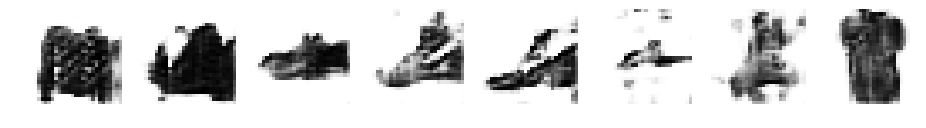

Epoch 021: time 27.737 sec, gen loss 1.682, disc loss 0.917


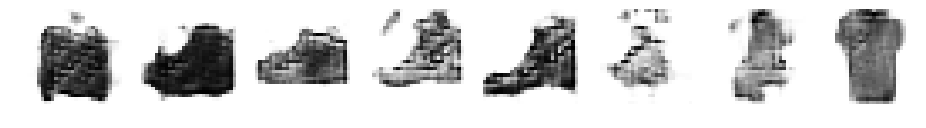

Epoch 022: time 27.858 sec, gen loss 1.683, disc loss 0.912


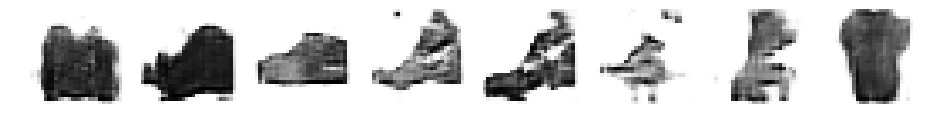

Epoch 023: time 27.954 sec, gen loss 1.679, disc loss 0.912


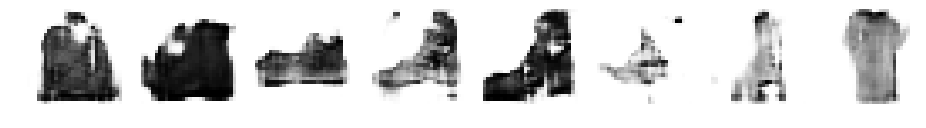

Epoch 024: time 27.855 sec, gen loss 1.679, disc loss 0.909


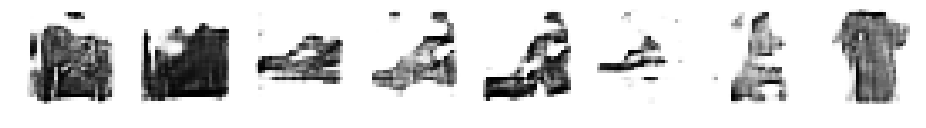

Epoch 025: time 28.047 sec, gen loss 1.679, disc loss 0.907


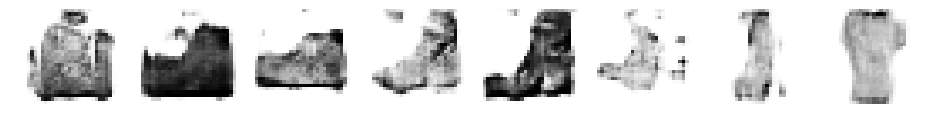

Epoch 026: time 27.924 sec, gen loss 1.676, disc loss 0.907


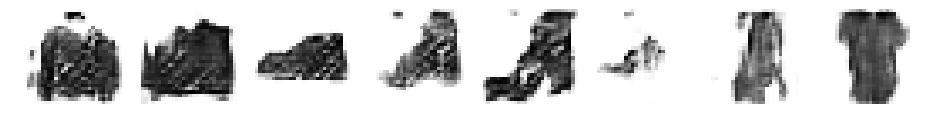

Epoch 027: time 27.902 sec, gen loss 1.674, disc loss 0.908


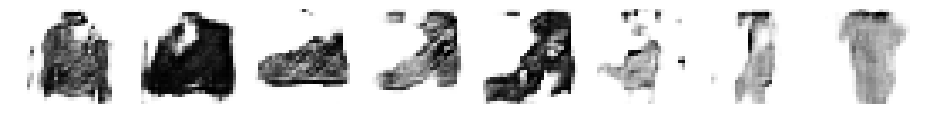

Epoch 028: time 28.057 sec, gen loss 1.670, disc loss 0.910


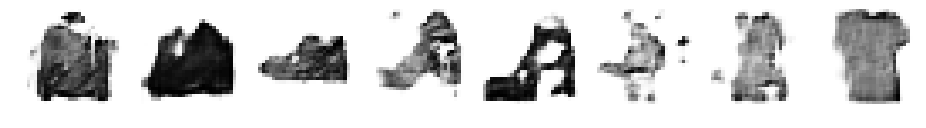

Epoch 029: time 27.535 sec, gen loss 1.669, disc loss 0.907


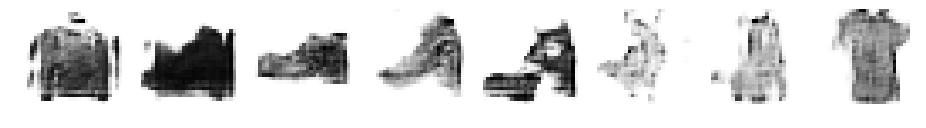

Epoch 030: time 27.574 sec, gen loss 1.668, disc loss 0.906


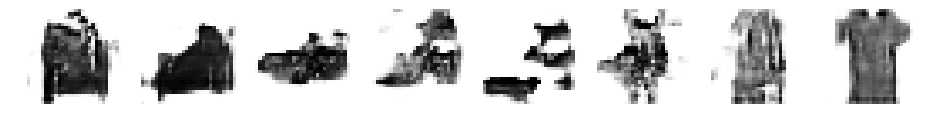

Epoch 031: time 27.602 sec, gen loss 1.666, disc loss 0.905


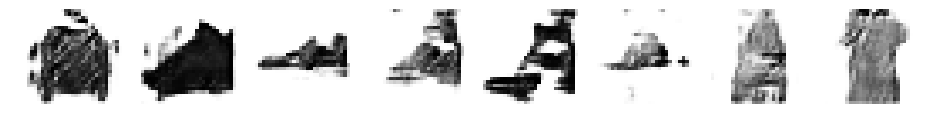

Epoch 032: time 27.713 sec, gen loss 1.662, disc loss 0.905


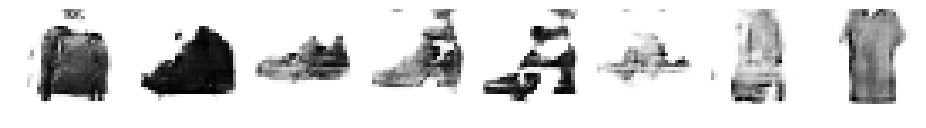

Epoch 033: time 28.145 sec, gen loss 1.658, disc loss 0.907


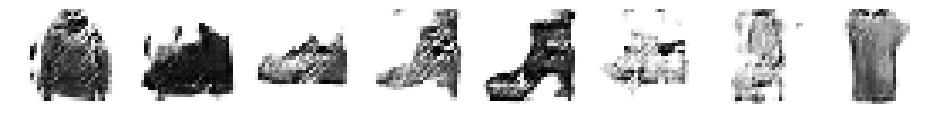

Epoch 034: time 27.538 sec, gen loss 1.654, disc loss 0.908


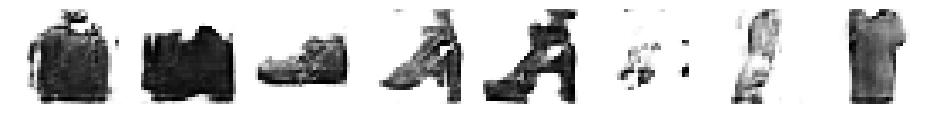

Epoch 035: time 27.565 sec, gen loss 1.653, disc loss 0.908


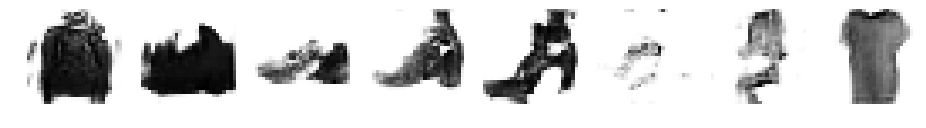

Epoch 036: time 27.636 sec, gen loss 1.650, disc loss 0.908


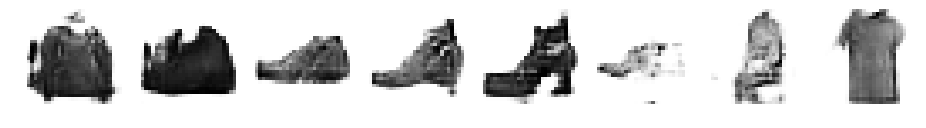

Epoch 037: time 27.550 sec, gen loss 1.649, disc loss 0.907


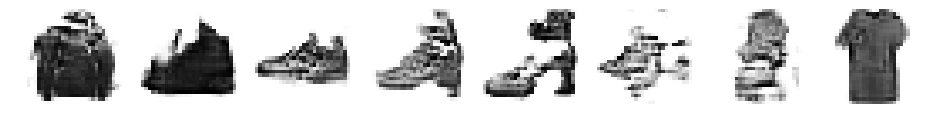

Epoch 038: time 27.619 sec, gen loss 1.648, disc loss 0.906


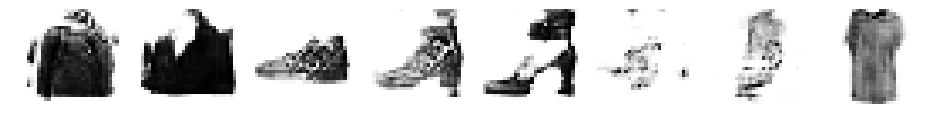

Epoch 039: time 27.685 sec, gen loss 1.647, disc loss 0.906


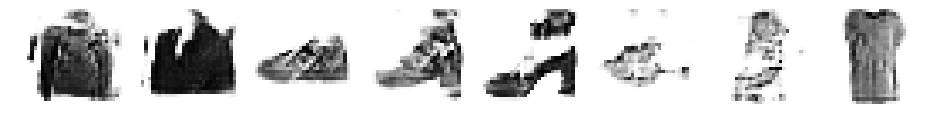

Epoch 040: time 27.664 sec, gen loss 1.648, disc loss 0.903


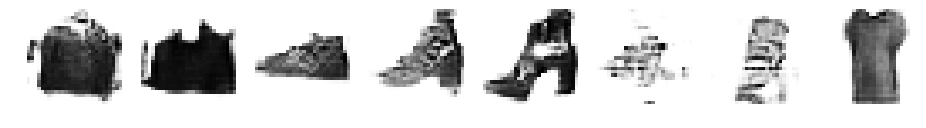

Epoch 041: time 27.597 sec, gen loss 1.647, disc loss 0.902


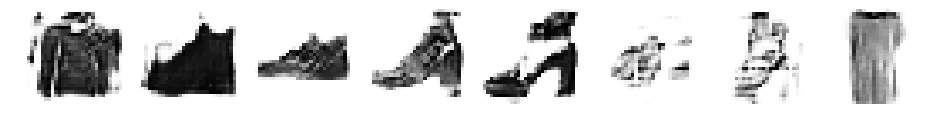

Epoch 042: time 27.710 sec, gen loss 1.648, disc loss 0.900


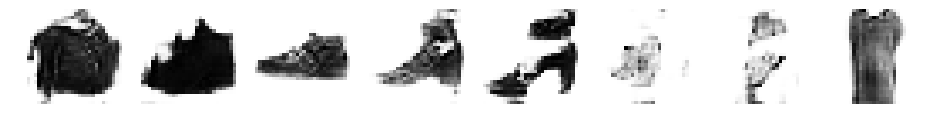

Epoch 043: time 27.799 sec, gen loss 1.648, disc loss 0.899


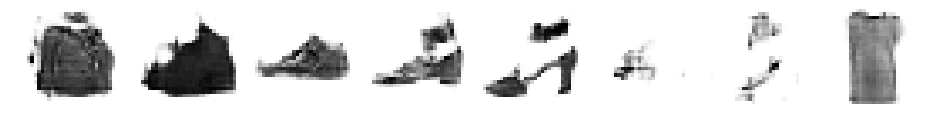

Epoch 044: time 27.959 sec, gen loss 1.646, disc loss 0.900


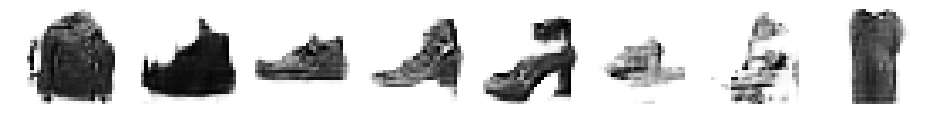

Epoch 045: time 27.882 sec, gen loss 1.646, disc loss 0.898


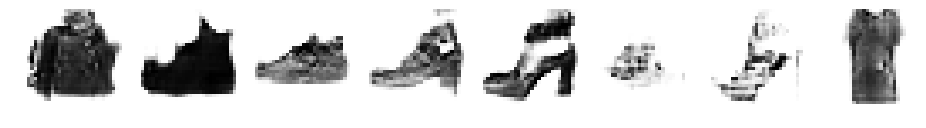

Epoch 046: time 27.794 sec, gen loss 1.645, disc loss 0.898


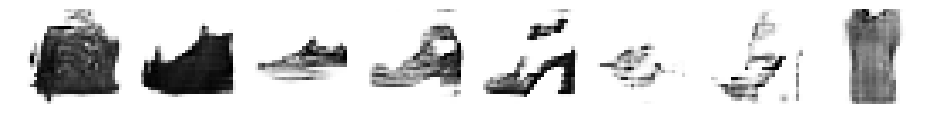

Epoch 047: time 28.132 sec, gen loss 1.645, disc loss 0.897


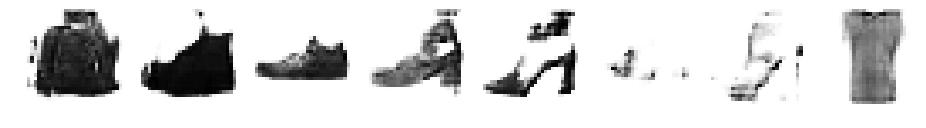

Epoch 048: time 27.622 sec, gen loss 1.644, disc loss 0.897


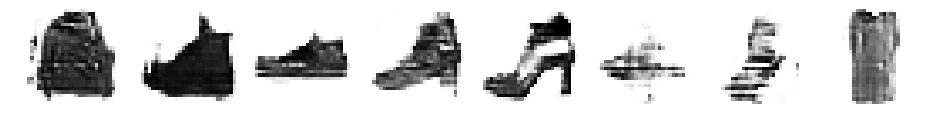

Epoch 049: time 27.734 sec, gen loss 1.644, disc loss 0.897


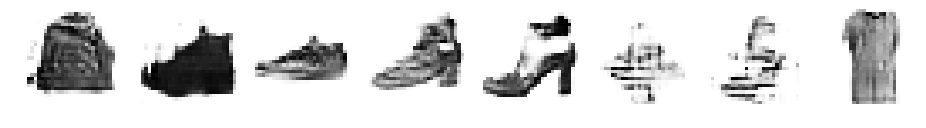

Epoch 050: time 28.071 sec, gen loss 1.643, disc loss 0.897


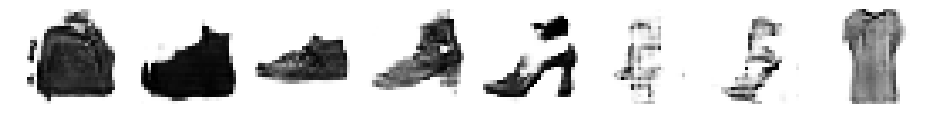

In [12]:
num_epochs = 20
train_GAN(num_epochs)

We go from the generator making images which are just noise- to actually producing "new" and real looking images of the Fashion MNIST clothes. This means the network has learned $p(x)$

## Common Problems?

• Not converging!: Discriminator is too good so generator fails

Solution: Add noise to discriminator input ([Arjovsky & Bottou](https://arxiv.org/pdf/1701.04862.pdf))

• Vanishing gradients: Discriminator is too good so generator fails

Solution: Use Wasserstein Loss ([link](https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html))

• Mode collapse: Generator produces the same examples 

Solution: Wasserstein Loss or Unrolled GAN ([Metz et al](https://arxiv.org/pdf/1611.02163.pdf))


## Further

Check out the [GAN Zoo](https://github.com/hindupuravinash/the-gan-zoo
) for all the crazy GAN applications